In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


# Define functions for pruning

In [2]:
# app = track_info['appearances']
def get_real_img_nums_dict(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]

    real_img_nums_dict = dict.fromkeys(range(batches))
    for batch in range(batches):
        real_img_nums_dict[batch] = {}

    # Gets number of real cells in each batch
    for batch in range(batches):
        for cell in range(cells):
            if np.max(app[batch, 0, cell]) != 0:
                last_frame = 71
                for frame in range(frames):
                    if np.max(app[batch, frame, cell]) == 0:
                        last_frame = frame
                        break
                real_img_nums_dict[batch][cell] = last_frame
            else:
                break
    return real_img_nums_dict

In [3]:
def get_real_img_array(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    real_img_list = []
    real_img_nums_dict = get_real_img_nums_dict(app)
    for batch in range(batches):
        for cell in real_img_nums_dict[batch].keys():
            for frame in range(real_img_nums_dict[batch][cell]):
                real_img_list.append(app[batch][frame][cell])
    appearances = np.array(real_img_list)
    return appearances

In [4]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [5]:
def prepare_dataset(appearances, batch_size=1, buffer_size=256,
                    seed=None):
    app_shape = np.shape(appearances)

    # Appearances not being normalized yet (will have to slightly modify norm function
    # since we don't have this organized by life cycle
    appearances = norm(appearances)

    dataset = tf.data.Dataset.from_tensor_slices((appearances, appearances))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Load the train data

In [6]:
%%time
# data loading
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_train_trks = '/training/tracking-nuclear/train.trks'
    all_train_data = [load_trks(path_temp_train_trks)]
    
    all_train_tracks = [Track(tracked_data=d) for d in all_train_data]
    
    train_track_info = concat_tracks(all_train_tracks)
    
    train_appearances = get_real_img_array(train_track_info['appearances'])
    
    train_dataset = prepare_dataset(train_appearances, batch_size=100)

2022-07-20 21:29:05.708885: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 21:29:07.112685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
100%|███████████████████████████████████████████| 91/91 [11:20<00:00,  7.48s/it]
2022-07-20 21:51:32.656222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5645002080 exceeds 10% of free system memory.


CPU times: user 1h 25min 37s, sys: 1h 27min 12s, total: 2h 52min 50s
Wall time: 34min 4s


2022-07-20 22:03:06.798139: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2734931968 exceeds 10% of free system memory.
2022-07-20 22:03:08.286059: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2734931968 exceeds 10% of free system memory.


# Load the validation data

In [7]:
%%time
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_val_trks = '/training/tracking-nuclear/val.trks'
    all_val_data = [load_trks(path_temp_val_trks)]
    
    all_val_tracks = [Track(tracked_data=d) for d in all_val_data]
    
    val_track_info = concat_tracks(all_val_tracks)
    
    val_appearances = get_real_img_array(val_track_info['appearances'])
    
    val_dataset = prepare_dataset(val_appearances, batch_size=100)

100%|███████████████████████████████████████████| 27/27 [01:54<00:00,  4.25s/it]


CPU times: user 19min 36s, sys: 20min 22s, total: 39min 59s
Wall time: 7min 40s


# Define the model

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [50]:
class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (32, 32, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(8*8*32, activation=None))
        layers.append(tfkl.Reshape((8,8,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(1024), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [51]:
vae = VAE_MNIST(128, 1, 1e-3)

In [52]:
AE = vae.build_vae_keras_model()

In [53]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '~/models/model_1'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3337/3339 [============================>.] - ETA: 0s - loss: -1396.9698
Epoch 1: val_loss improved from inf to -1573.36707, saving model to ~/models/model_1
3339/3339 [==============================] - 42s 12ms/step - loss: -1397.0204 - val_loss: -1573.3671 - lr: 0.0010
Epoch 2/15
3335/3339 [============================>.] - ETA: 0s - loss: -2114.5081
Epoch 2: val_loss improved from -1573.36707 to -1956.21484, saving model to ~/models/model_1
3339/3339 [==============================] - 39s 12ms/step - loss: -2113.9226 - val_loss: -1956.2148 - lr: 0.0010
Epoch 3/15
3336/3339 [============================>.] - ETA: 0s - loss: -2295.3018
Epoch 3: val_loss improved from -1956.21484 to -2153.68408, saving model to ~/models/model_1
3339/3339 [==============================] - 39s 12ms/step - loss: -2294.8699 - val_loss: -2153.6841 - lr: 0.0010
Epoch 4/15
3337/3339 [============================>.] - ETA: 0s - loss: -2391.4866
Epoch 4: val_loss improved from -2153.68408 to -2263.00

In [17]:
train_appearances.shape

(333854, 32, 32, 1)

In [18]:
val_appearances.shape

(78352, 32, 32, 1)

In [21]:
# Still has the error when not monitoring val_loss and (naturally) not saving best only

In [37]:
x = np.array([train_appearances[0]])

In [38]:
xhat = AE(x).mean()

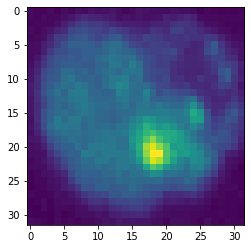

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(x[0])

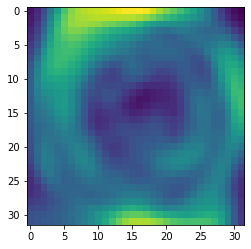

In [40]:
fig, ax = plt.subplots()
ax.imshow(xhat[0])

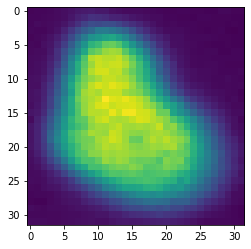

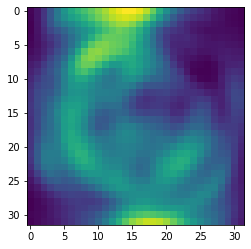

In [41]:
x = np.array([train_appearances[1234]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

# Try a bigger embedding layer

In [43]:
vae2 = VAE_MNIST(512, 1, 1e-3)

In [44]:
AE2 = vae2.build_vae_keras_model()

In [45]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '~/models/model_2'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE2.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3335/3339 [============================>.] - ETA: 0s - loss: -1336.7378
Epoch 1: val_loss improved from inf to -1505.33350, saving model to ~/models/model_2
3339/3339 [==============================] - 42s 12ms/step - loss: -1336.7501 - val_loss: -1505.3335 - lr: 0.0010
Epoch 2/15
3337/3339 [============================>.] - ETA: 0s - loss: -1996.8345
Epoch 2: val_loss improved from -1505.33350 to -1870.79565, saving model to ~/models/model_2
3339/3339 [==============================] - 39s 12ms/step - loss: -1996.6204 - val_loss: -1870.7957 - lr: 0.0010
Epoch 3/15
3337/3339 [============================>.] - ETA: 0s - loss: -2195.7202
Epoch 3: val_loss improved from -1870.79565 to -2042.91284, saving model to ~/models/model_2
3339/3339 [==============================] - 40s 12ms/step - loss: -2195.5142 - val_loss: -2042.9128 - lr: 0.0010
Epoch 4/15
3339/3339 [==============================] - ETA: 0s - loss: -2299.8459
Epoch 4: val_loss improved from -2042.91284 to -2146.70

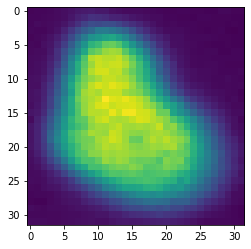

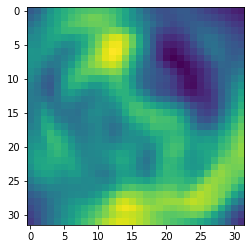

In [46]:
x = np.array([train_appearances[1234]])
xhat = AE2(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

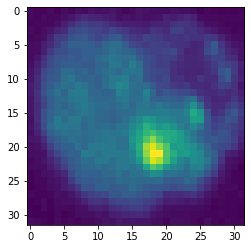

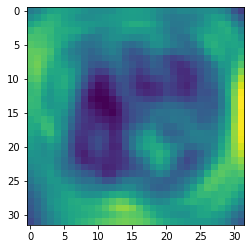

In [47]:
x = np.array([train_appearances[0]])
xhat = AE2(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

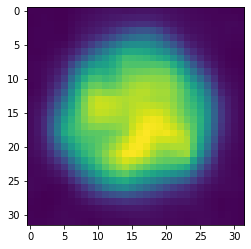

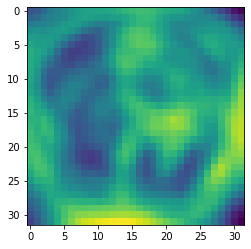

In [48]:
x = np.array([train_appearances[12345]])
xhat = AE2(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

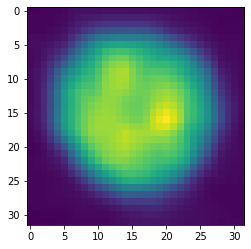

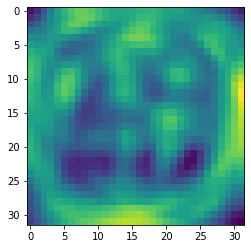

In [49]:
x = np.array([train_appearances[123456]])
xhat = AE2(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [ ]:
# maybe taking negative of loss or something